In [1]:
#load dragonn tutorial utilities 
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pickle 
import numpy as np 
from keras import backend as K 

Using TensorFlow backend.


In [3]:
data=pickle.load(open("ism.inputs.pkl",'rb'))
model=data[0] 
X=data[1]

In [4]:
def get_logit_function(model):
    from keras import backend as K
    inp=model.input
    outputs=model.layers[-2].output
    functor=K.function([inp], [outputs])
    return functor 

def get_logit(functor,X):
    logit=functor([X])
    return logit


In [5]:
X.shape

(1000, 1, 1500, 4)

In [6]:
def in_silico_mutagenesis(model, X):
    """                                                                                                                                                                                                      
    Parameters                                                                                                                                                                                               
    ----------                                                                                                                                                                                               
    model: keras model object                                                                                                                                                                                
    X: input matrix: (num_samples, 1, sequence_length,num_bases)                                                                                                                                            
    Returns                                                                                                                                                                                                  
    ---------                                                                                                                                                                                                
    (num_task, num_samples, sequence_length,num_bases) ISM score array.                                                                                                                                  
    """
    functor=get_logit_function(model)
    #1. get the wildtype predictions (n,1)                                                                                                                                                         
    wild_type_logits=np.asarray(get_logit(functor,X))
    wild_type_logits=np.squeeze(wild_type_logits,axis=2)
    #2. expand the wt array to dimensions: (num_samples,1,sequence_length)                                                                                                                         
    #Initialize mutants array to the same shape                                                                                                                                                              
    output_dim=wild_type_logits.shape+X.shape[2:4]
    wt_expanded=np.empty(output_dim)
    mutants_expanded=np.empty(output_dim)
    empty_onehot=np.zeros(output_dim[3])
    #3. Iterate through all tasks, positions                                                                                                                                                                 
    for task_index in range(output_dim[0]):
        for sample_index in range(output_dim[1]):
            print(str(task_index)+":"+str(sample_index))
            #fill in wild type logit values into an array of dim (task,sequence_length,num_bases)                                                                                                                    
            wt_logit_for_task_sample=wild_type_logits[task_index][sample_index]
            wt_expanded[task_index][sample_index]=np.tile(wt_logit_for_task_sample,(output_dim[2],output_dim[3]))
            #mutagenize each position                                                                                                                                                                            
            for base_pos in range(output_dim[2]):
                #for each position, iterate through the 4 bases                                                                                                                                                  
                for base_letter in range(output_dim[3]):
                    cur_base=empty_onehot
                    cur_base[base_letter]=1
                    Xtmp=np.expand_dims(X[sample_index],axis=0)
                    Xtmp[0][0][base_pos]=cur_base
                    #get the logit of Xtmp                                                                                                                                                                              
                    mutants_expanded[task_index][sample_index][base_pos][base_letter]=np.squeeze(get_logit(functor,Xtmp)[task_index])
    #subtract mutants_expanded from wt_expanded 
    ism_vals=wt_expanded-mutants_expanded
    #For each position subtract the mean ISM score for that position from each of the 4 values
    ism_vals_mean=np.expand_dims(np.mean(ism_vals,axis=3),axis=3)
    ism_vals_normed=ism_vals-ism_vals_mean
    return ism_vals_normed

In [7]:
ism_values=in_silico_mutagenesis(model,X[100:105])

0:0
0:1
0:2
0:3
0:4


In [8]:
ism_values.shape

(1, 5, 1500, 4)

In [9]:
#plotting! 
#Plot the 4xL heatmap 
#and also the identity and score of the highest scoring (mean subtracted) allele at each position 
#(that will look like a DeepLIFT/grad*input track)

In [10]:
import matplotlib
from matplotlib import pyplot as plt


In [11]:
from dragonn.vis import * 
from dragonn.vis.plot_letters import * 

In [12]:
example=ism_values[0][3]

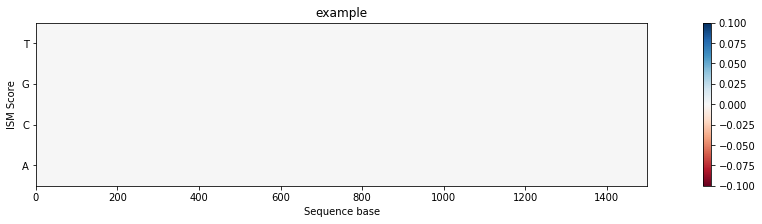

In [13]:
plot_ism(example,'example')

In [14]:
highest_scoring_pos=np.argmax(np.abs(example),axis=1)

In [15]:
zero_map=np.zeros(example.shape)

In [16]:
zero_map[:,highest_scoring_pos]=1

In [17]:
zero_map

array([[1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       ...,
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.]])

In [18]:
product=zero_map*example

In [19]:
np.max(product)

0.0

RuntimeError: No mappable was found to use for colorbar creation. First define a mappable such as an image (with imshow) or a contour set (with contourf).

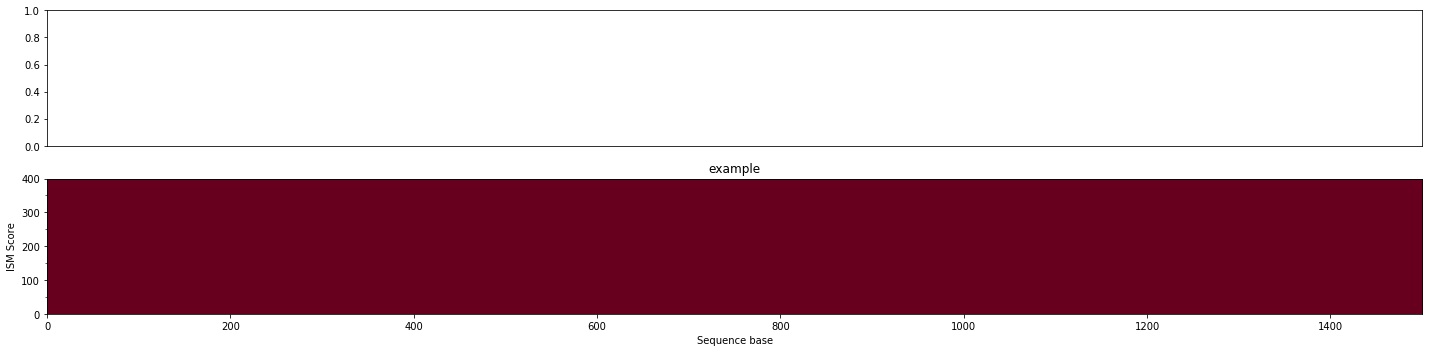

In [28]:
fig,axes=plt.subplots(2, 1,sharex='row',figsize=(20,5))
ism_mat=example
axes[0]=plot_bases_on_ax(product,axes[0],show_ticks=False)
extent = [0, ism_mat.shape[0], 0, 100*ism_mat.shape[1]]
vmin=np.amin(ism_mat)
vmax=np.amax(ism_mat)
axes[1].imshow(ism_mat.T,extent=extent,vmin=vmin, vmax=vmax, interpolation='nearest',aspect='auto')
axes[1].set_xlabel("Sequence base")
axes[1].set_ylabel("ISM Score")
axes[1].set_title("example")
axes[1].set_yticks(np.arange(50,100*ism_mat.shape[1],100),("A","C","G","T"))
plt.set_cmap('RdBu')
plt.tight_layout()
plt.colorbar()
plt.show()

[]

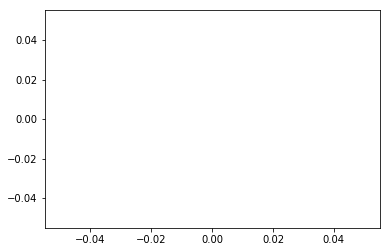

In [21]:
plt.plot()

In [22]:
f.tight_layout()
plt.show()

NameError: name 'f' is not defined